In [1]:
import pandas as pd
import deepchem as dc
import numpy as np
from tqdm import tqdm
import torch
import data_utils as HIVLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

/home/daffaizzuddin/miniconda3/envs/interna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-11 14:03:49.237453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 14:03:49.805882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


## Load Datasets

In [2]:
df = HIVLoader.load_main_data()
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,False
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,False
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,False
4,O=S(=O)(O)CCS(=O)(=O)O,CI,False


## Data Preparation

In [3]:
(train_ds, val_ds, test_ds) = HIVLoader.random_split(df, undersampling=True)
print(f'total: {len(train_ds):5d}, active: {sum(train_ds.y):4d}, inactive: {sum(train_ds.y == False):5d}')
print(f'total: {len(val_ds):5d}, active: {sum(val_ds.y):4d}, inactive: {sum(val_ds.y == False):5d}')
print(f'total: {len(test_ds):5d}, active: {sum(test_ds.y):4d}, inactive: {sum(test_ds.y == False):5d}')

total:  2001, active: 1002, inactive:   999
total:   572, active:  292, inactive:   280
total:   287, active:  136, inactive:   151


In [4]:
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
transformer = dc.trans.FeaturizationTransformer(featurizer=featurizer)

train_feat = train_ds.transform(transformer)
val_feat = val_ds.transform(transformer)
test_feat = test_ds.transform(transformer)

## Modelling

In [5]:
from typing import Any

def print_dict(dictionary, sep=', '):
  result = [f'{k}: {v:.4f}' for k, v in dictionary.items()]
  print(sep.join(result))

def train_model(create_model, train_data, test_data, transformer, save_dir, epoch=60, batch_size=64):
  optimizer = dc.models.optimizers.Adam(0.001)
  model = create_model()
  
  metrics = [dc.metrics.Metric(metric) for metric in [roc_auc_score, f1_score, accuracy_score, recall_score]]
  best_metric = {
    'f1_score': float('-inf'),
    'roc_auc_score': float('-inf'),
    'recall_score': float('-inf')
  }
  
  for i in range(epoch):
    losses = []
    for X, y, w, _ in tqdm(train_data.iterbatches(batch_size), total=np.ceil(len(train_feat)/batch_size)):
      loss = model.fit_on_batch(X, y, w)
      losses.append(loss)
    
    result_metrics = model.evaluate(test_data, metrics, transformers=[transformer])
    result_metrics['train_loss'] = np.mean(np.array(losses))
    result_metrics['epoch'] = i
    
    for metric, value in best_metric.items():
      if result_metrics[metric] > value:
        best_metric[metric] = result_metrics[metric]
        model.save_checkpoint(1, os.path.join(save_dir, f'best_{metric}'))
    
    print_dict(result_metrics)
  
  best_model = {}
  for metric, score in best_metric.items():
    _model = create_model()
    _model.restore(os.path.join(save_dir, f'best_{metric}', 'checkpoint1.pt'))
    best_model[metric] = (_model, score)
    
  return best_model

def evaluate_model(model, dataset):
  metrics = [dc.metrics.Metric(metric) for metric in [roc_auc_score, f1_score, accuracy_score, recall_score]]
  result_metrics = model.evaluate(dataset, metrics, transformers=[transformer])
  
  logits = model.predict(dataset, transformers=[transformer])
  preds = np.argmax(logits, axis=1)

  cm = confusion_matrix(test_feat.y, preds, normalize='true')
  disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm)
  
  cm = confusion_matrix(test_feat.y, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  
  return result_metrics, (disp, disp_norm)

### Graph Convolution Model

In [6]:
gcn_model = lambda optimizer=None: dc.models.GCNModel(
  mode='classification',
  n_tasks=1,
  learning_rate=0.001,
  device=torch.device('cuda'),
  optimizer=optimizer
)
best_gcn_model = train_model(gcn_model, train_feat, val_feat, transformer, save_dir='checkpoints/GCM_undersampled')

100%|██████████| 32/32.0 [00:02<00:00, 15.65it/s]


roc_auc_score: 0.6711, f1_score: 0.6722, accuracy_score: 0.5822, recall_score: 0.8390, train_loss: 0.4040, epoch: 0.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.56it/s]


roc_auc_score: 0.7008, f1_score: 0.6835, accuracy_score: 0.6276, recall_score: 0.7877, train_loss: 0.3833, epoch: 1.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.45it/s]


roc_auc_score: 0.7114, f1_score: 0.6810, accuracy_score: 0.6364, recall_score: 0.7603, train_loss: 0.3774, epoch: 2.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.56it/s]


roc_auc_score: 0.7243, f1_score: 0.6172, accuracy_score: 0.6661, recall_score: 0.5274, train_loss: 0.3727, epoch: 3.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.15it/s]


roc_auc_score: 0.7516, f1_score: 0.6692, accuracy_score: 0.6941, recall_score: 0.6062, train_loss: 0.3621, epoch: 4.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.01it/s]


roc_auc_score: 0.7216, f1_score: 0.5173, accuracy_score: 0.6346, recall_score: 0.3836, train_loss: 0.3591, epoch: 5.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.00it/s]


roc_auc_score: 0.7450, f1_score: 0.4988, accuracy_score: 0.6451, recall_score: 0.3459, train_loss: 0.3534, epoch: 6.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.52it/s]


roc_auc_score: 0.7651, f1_score: 0.7125, accuracy_score: 0.6713, recall_score: 0.7979, train_loss: 0.3419, epoch: 7.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.73it/s]


roc_auc_score: 0.7322, f1_score: 0.6971, accuracy_score: 0.6871, recall_score: 0.7055, train_loss: 0.3356, epoch: 8.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.75it/s]


roc_auc_score: 0.7526, f1_score: 0.7067, accuracy_score: 0.7098, recall_score: 0.6849, train_loss: 0.3328, epoch: 9.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.32it/s]


roc_auc_score: 0.7728, f1_score: 0.4836, accuracy_score: 0.6416, recall_score: 0.3288, train_loss: 0.3181, epoch: 10.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.33it/s]


roc_auc_score: 0.7262, f1_score: 0.6818, accuracy_score: 0.5822, recall_score: 0.8767, train_loss: 0.3186, epoch: 11.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.05it/s]


roc_auc_score: 0.7871, f1_score: 0.6903, accuracy_score: 0.7255, recall_score: 0.5993, train_loss: 0.3176, epoch: 12.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.68it/s]


roc_auc_score: 0.8007, f1_score: 0.5855, accuracy_score: 0.6906, recall_score: 0.4281, train_loss: 0.2944, epoch: 13.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.05it/s]


roc_auc_score: 0.7928, f1_score: 0.4118, accuracy_score: 0.6154, recall_score: 0.2637, train_loss: 0.2915, epoch: 14.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.93it/s]


roc_auc_score: 0.7795, f1_score: 0.6336, accuracy_score: 0.7028, recall_score: 0.5034, train_loss: 0.2791, epoch: 15.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.04it/s]


roc_auc_score: 0.7931, f1_score: 0.6653, accuracy_score: 0.7203, recall_score: 0.5445, train_loss: 0.2726, epoch: 16.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.99it/s]


roc_auc_score: 0.7857, f1_score: 0.6876, accuracy_score: 0.7220, recall_score: 0.5993, train_loss: 0.2726, epoch: 17.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.96it/s]


roc_auc_score: 0.7848, f1_score: 0.6865, accuracy_score: 0.7238, recall_score: 0.5925, train_loss: 0.2521, epoch: 18.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.43it/s]


roc_auc_score: 0.8112, f1_score: 0.7050, accuracy_score: 0.7395, recall_score: 0.6096, train_loss: 0.2481, epoch: 19.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.34it/s]


roc_auc_score: 0.8101, f1_score: 0.7222, accuracy_score: 0.7378, recall_score: 0.6678, train_loss: 0.2469, epoch: 20.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.99it/s]


roc_auc_score: 0.7992, f1_score: 0.7385, accuracy_score: 0.7028, recall_score: 0.8219, train_loss: 0.2414, epoch: 21.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.40it/s]


roc_auc_score: 0.7545, f1_score: 0.7103, accuracy_score: 0.6748, recall_score: 0.7808, train_loss: 0.2303, epoch: 22.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.10it/s]


roc_auc_score: 0.7823, f1_score: 0.7273, accuracy_score: 0.7063, recall_score: 0.7671, train_loss: 0.2187, epoch: 23.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.91it/s]


roc_auc_score: 0.7865, f1_score: 0.7264, accuracy_score: 0.7010, recall_score: 0.7774, train_loss: 0.2145, epoch: 24.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.31it/s]


roc_auc_score: 0.7770, f1_score: 0.6667, accuracy_score: 0.7098, recall_score: 0.5685, train_loss: 0.2146, epoch: 25.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.76it/s]


roc_auc_score: 0.8089, f1_score: 0.7406, accuracy_score: 0.7465, recall_score: 0.7089, train_loss: 0.2034, epoch: 26.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.85it/s]


roc_auc_score: 0.7781, f1_score: 0.7050, accuracy_score: 0.6049, recall_score: 0.9247, train_loss: 0.1910, epoch: 27.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.95it/s]


roc_auc_score: 0.7782, f1_score: 0.5180, accuracy_score: 0.6486, recall_score: 0.3699, train_loss: 0.1938, epoch: 28.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.69it/s]


roc_auc_score: 0.7891, f1_score: 0.7231, accuracy_score: 0.7080, recall_score: 0.7466, train_loss: 0.2033, epoch: 29.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.04it/s]


roc_auc_score: 0.7723, f1_score: 0.6919, accuracy_score: 0.7150, recall_score: 0.6267, train_loss: 0.1860, epoch: 30.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.27it/s]


roc_auc_score: 0.8033, f1_score: 0.7354, accuracy_score: 0.7308, recall_score: 0.7329, train_loss: 0.1790, epoch: 31.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.73it/s]


roc_auc_score: 0.8033, f1_score: 0.7559, accuracy_score: 0.7483, recall_score: 0.7637, train_loss: 0.1658, epoch: 32.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.60it/s]


roc_auc_score: 0.7887, f1_score: 0.4199, accuracy_score: 0.6136, recall_score: 0.2740, train_loss: 0.1613, epoch: 33.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.53it/s]


roc_auc_score: 0.7893, f1_score: 0.6708, accuracy_score: 0.7203, recall_score: 0.5582, train_loss: 0.1668, epoch: 34.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.76it/s]


roc_auc_score: 0.8006, f1_score: 0.6099, accuracy_score: 0.6958, recall_score: 0.4658, train_loss: 0.1544, epoch: 35.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.61it/s]


roc_auc_score: 0.7793, f1_score: 0.6955, accuracy_score: 0.7168, recall_score: 0.6336, train_loss: 0.1429, epoch: 36.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.25it/s]


roc_auc_score: 0.7922, f1_score: 0.7298, accuracy_score: 0.7255, recall_score: 0.7260, train_loss: 0.1477, epoch: 37.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.84it/s]


roc_auc_score: 0.7813, f1_score: 0.6242, accuracy_score: 0.6906, recall_score: 0.5034, train_loss: 0.1368, epoch: 38.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.21it/s]


roc_auc_score: 0.7774, f1_score: 0.7139, accuracy_score: 0.6469, recall_score: 0.8630, train_loss: 0.1311, epoch: 39.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.63it/s]


roc_auc_score: 0.7725, f1_score: 0.6444, accuracy_score: 0.7028, recall_score: 0.5274, train_loss: 0.1365, epoch: 40.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.85it/s]


roc_auc_score: 0.7658, f1_score: 0.7103, accuracy_score: 0.6364, recall_score: 0.8733, train_loss: 0.1336, epoch: 41.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.43it/s]


roc_auc_score: 0.7711, f1_score: 0.7287, accuracy_score: 0.6888, recall_score: 0.8185, train_loss: 0.1257, epoch: 42.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.58it/s]


roc_auc_score: 0.7937, f1_score: 0.6570, accuracy_score: 0.7098, recall_score: 0.5445, train_loss: 0.1275, epoch: 43.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.26it/s]


roc_auc_score: 0.7692, f1_score: 0.6769, accuracy_score: 0.7063, recall_score: 0.6027, train_loss: 0.1309, epoch: 44.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.49it/s]


roc_auc_score: 0.7802, f1_score: 0.7270, accuracy_score: 0.6941, recall_score: 0.7979, train_loss: 0.1194, epoch: 45.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.32it/s]


roc_auc_score: 0.7866, f1_score: 0.7259, accuracy_score: 0.6923, recall_score: 0.7979, train_loss: 0.1122, epoch: 46.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.71it/s]


roc_auc_score: 0.8084, f1_score: 0.6091, accuracy_score: 0.6993, recall_score: 0.4589, train_loss: 0.1037, epoch: 47.0000


100%|██████████| 32/32.0 [00:01<00:00, 27.02it/s]


roc_auc_score: 0.7906, f1_score: 0.7308, accuracy_score: 0.7063, recall_score: 0.7808, train_loss: 0.0855, epoch: 48.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.86it/s]


roc_auc_score: 0.7832, f1_score: 0.7282, accuracy_score: 0.7325, recall_score: 0.7021, train_loss: 0.0969, epoch: 49.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.87it/s]


roc_auc_score: 0.7773, f1_score: 0.7031, accuracy_score: 0.7150, recall_score: 0.6610, train_loss: 0.1011, epoch: 50.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.72it/s]


roc_auc_score: 0.7905, f1_score: 0.7352, accuracy_score: 0.7255, recall_score: 0.7466, train_loss: 0.1088, epoch: 51.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.67it/s]


roc_auc_score: 0.7822, f1_score: 0.7198, accuracy_score: 0.6434, recall_score: 0.8973, train_loss: 0.0773, epoch: 52.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.95it/s]


roc_auc_score: 0.7719, f1_score: 0.7138, accuracy_score: 0.6748, recall_score: 0.7945, train_loss: 0.0999, epoch: 53.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.43it/s]


roc_auc_score: 0.7886, f1_score: 0.6826, accuracy_score: 0.7220, recall_score: 0.5856, train_loss: 0.1070, epoch: 54.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.96it/s]


roc_auc_score: 0.7998, f1_score: 0.7406, accuracy_score: 0.7343, recall_score: 0.7432, train_loss: 0.0820, epoch: 55.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.75it/s]


roc_auc_score: 0.8010, f1_score: 0.6304, accuracy_score: 0.7028, recall_score: 0.4966, train_loss: 0.0818, epoch: 56.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.52it/s]


roc_auc_score: 0.7861, f1_score: 0.7140, accuracy_score: 0.7255, recall_score: 0.6712, train_loss: 0.0753, epoch: 57.0000


100%|██████████| 32/32.0 [00:01<00:00, 26.56it/s]


roc_auc_score: 0.7733, f1_score: 0.6916, accuracy_score: 0.6976, recall_score: 0.6644, train_loss: 0.0988, epoch: 58.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.69it/s]


roc_auc_score: 0.7956, f1_score: 0.6994, accuracy_score: 0.7325, recall_score: 0.6096, train_loss: 0.0951, epoch: 59.0000


Model evaluation with val f1_score:0.7559
roc_auc_score: 0.7908
f1_score: 0.7158
accuracy_score: 0.7178
recall_score: 0.7500


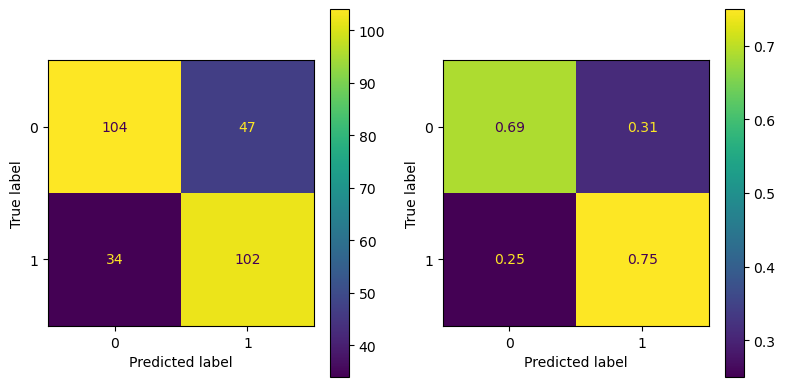

Model evaluation with val roc_auc_score:0.8112
roc_auc_score: 0.7995
f1_score: 0.6908
accuracy_score: 0.7317
recall_score: 0.6324


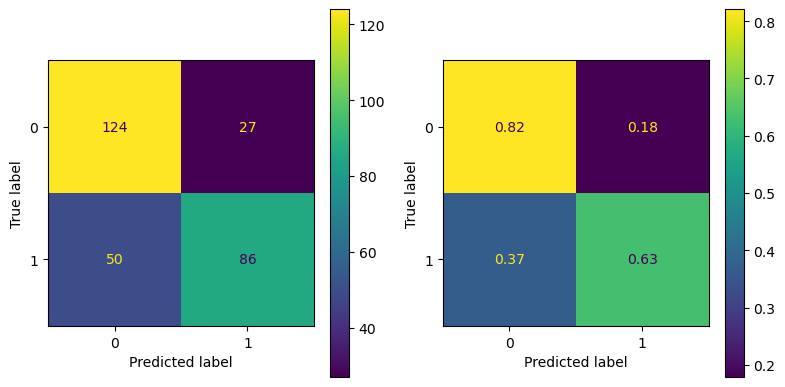

Model evaluation with val recall_score:0.9247
roc_auc_score: 0.7884
f1_score: 0.6701
accuracy_score: 0.5505
recall_score: 0.9632


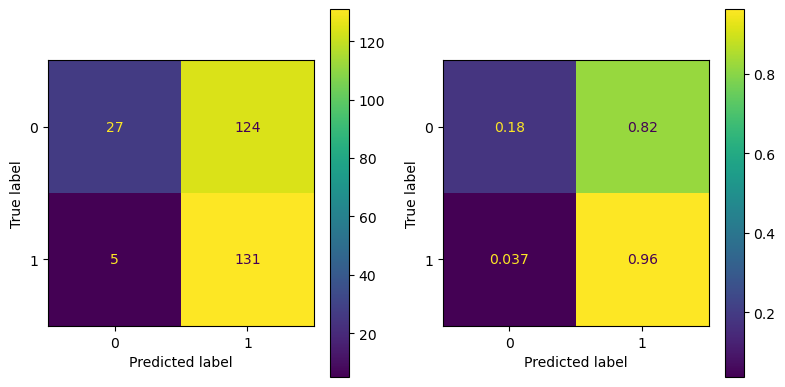

In [7]:
for i, (metric, (model, score)) in enumerate(best_gcn_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with val {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()

### AttentiveFP

In [8]:
afp_model = lambda optimizer=None: dc.models.AttentiveFPModel(
  mode='classification',
  n_tasks=1,
  learning_rate=0.001,
  device=torch.device('cuda'),
  optimizer=optimizer
)
best_afp_model = train_model(afp_model, train_feat, val_feat, transformer, save_dir='checkpoints/AtentiveFP_undersampled')

100%|██████████| 32/32.0 [00:02<00:00, 12.69it/s]


roc_auc_score: 0.6623, f1_score: 0.5011, accuracy_score: 0.6206, recall_score: 0.3733, train_loss: 0.4300, epoch: 0.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.78it/s]


roc_auc_score: 0.6830, f1_score: 0.6088, accuracy_score: 0.6136, recall_score: 0.5890, train_loss: 0.4013, epoch: 1.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.15it/s]


roc_auc_score: 0.7072, f1_score: 0.4854, accuracy_score: 0.6294, recall_score: 0.3425, train_loss: 0.3926, epoch: 2.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.21it/s]


roc_auc_score: 0.7145, f1_score: 0.6078, accuracy_score: 0.6661, recall_score: 0.5068, train_loss: 0.3885, epoch: 3.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.94it/s]


roc_auc_score: 0.7324, f1_score: 0.6054, accuracy_score: 0.6696, recall_score: 0.4966, train_loss: 0.3772, epoch: 4.0000


100%|██████████| 32/32.0 [00:02<00:00, 12.18it/s]


roc_auc_score: 0.7351, f1_score: 0.6210, accuracy_score: 0.6713, recall_score: 0.5274, train_loss: 0.3702, epoch: 5.0000


100%|██████████| 32/32.0 [00:02<00:00, 12.54it/s]


roc_auc_score: 0.7401, f1_score: 0.6107, accuracy_score: 0.6678, recall_score: 0.5103, train_loss: 0.3682, epoch: 6.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.90it/s]


roc_auc_score: 0.7436, f1_score: 0.6328, accuracy_score: 0.6713, recall_score: 0.5548, train_loss: 0.3622, epoch: 7.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.27it/s]


roc_auc_score: 0.7312, f1_score: 0.6815, accuracy_score: 0.6241, recall_score: 0.7877, train_loss: 0.3601, epoch: 8.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.87it/s]


roc_auc_score: 0.7482, f1_score: 0.6983, accuracy_score: 0.6888, recall_score: 0.7055, train_loss: 0.3596, epoch: 9.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.15it/s]


roc_auc_score: 0.7540, f1_score: 0.6799, accuracy_score: 0.6906, recall_score: 0.6438, train_loss: 0.3498, epoch: 10.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.06it/s]


roc_auc_score: 0.7570, f1_score: 0.7085, accuracy_score: 0.6993, recall_score: 0.7158, train_loss: 0.3415, epoch: 11.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.17it/s]


roc_auc_score: 0.7494, f1_score: 0.6842, accuracy_score: 0.6853, recall_score: 0.6678, train_loss: 0.3422, epoch: 12.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.02it/s]


roc_auc_score: 0.7748, f1_score: 0.6908, accuracy_score: 0.7168, recall_score: 0.6199, train_loss: 0.3356, epoch: 13.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.70it/s]


roc_auc_score: 0.7649, f1_score: 0.7096, accuracy_score: 0.7080, recall_score: 0.6986, train_loss: 0.3296, epoch: 14.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.17it/s]


roc_auc_score: 0.7735, f1_score: 0.7197, accuracy_score: 0.7290, recall_score: 0.6815, train_loss: 0.3213, epoch: 15.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.35it/s]


roc_auc_score: 0.7717, f1_score: 0.6795, accuracy_score: 0.7098, recall_score: 0.6027, train_loss: 0.3229, epoch: 16.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.87it/s]


roc_auc_score: 0.7715, f1_score: 0.7183, accuracy_score: 0.7010, recall_score: 0.7466, train_loss: 0.3112, epoch: 17.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.84it/s]


roc_auc_score: 0.7673, f1_score: 0.7125, accuracy_score: 0.7220, recall_score: 0.6747, train_loss: 0.3043, epoch: 18.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.56it/s]


roc_auc_score: 0.7791, f1_score: 0.7368, accuracy_score: 0.7290, recall_score: 0.7432, train_loss: 0.2941, epoch: 19.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.02it/s]


roc_auc_score: 0.7845, f1_score: 0.7416, accuracy_score: 0.7308, recall_score: 0.7568, train_loss: 0.2973, epoch: 20.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.29it/s]


roc_auc_score: 0.7886, f1_score: 0.7084, accuracy_score: 0.7395, recall_score: 0.6199, train_loss: 0.2899, epoch: 21.0000


100%|██████████| 32/32.0 [00:02<00:00, 12.77it/s]


roc_auc_score: 0.7803, f1_score: 0.7306, accuracy_score: 0.7203, recall_score: 0.7432, train_loss: 0.2865, epoch: 22.0000


100%|██████████| 32/32.0 [00:02<00:00, 11.39it/s]


roc_auc_score: 0.7781, f1_score: 0.7254, accuracy_score: 0.7273, recall_score: 0.7055, train_loss: 0.2782, epoch: 23.0000


100%|██████████| 32/32.0 [00:02<00:00, 11.58it/s]


roc_auc_score: 0.7867, f1_score: 0.7063, accuracy_score: 0.7325, recall_score: 0.6301, train_loss: 0.2655, epoch: 24.0000


100%|██████████| 32/32.0 [00:02<00:00, 11.20it/s]


roc_auc_score: 0.7684, f1_score: 0.6694, accuracy_score: 0.7220, recall_score: 0.5514, train_loss: 0.2583, epoch: 25.0000


100%|██████████| 32/32.0 [00:05<00:00,  6.10it/s]


roc_auc_score: 0.7678, f1_score: 0.6954, accuracy_score: 0.6661, recall_score: 0.7466, train_loss: 0.2658, epoch: 26.0000


100%|██████████| 32/32.0 [00:05<00:00,  6.36it/s]


roc_auc_score: 0.7897, f1_score: 0.7221, accuracy_score: 0.7430, recall_score: 0.6541, train_loss: 0.2617, epoch: 27.0000


100%|██████████| 32/32.0 [00:02<00:00, 10.96it/s]


roc_auc_score: 0.7658, f1_score: 0.7123, accuracy_score: 0.7133, recall_score: 0.6952, train_loss: 0.2333, epoch: 28.0000


100%|██████████| 32/32.0 [00:04<00:00,  6.91it/s]


roc_auc_score: 0.7740, f1_score: 0.7253, accuracy_score: 0.7325, recall_score: 0.6918, train_loss: 0.2340, epoch: 29.0000


100%|██████████| 32/32.0 [00:05<00:00,  5.76it/s]


roc_auc_score: 0.7789, f1_score: 0.7254, accuracy_score: 0.7220, recall_score: 0.7192, train_loss: 0.2289, epoch: 30.0000


100%|██████████| 32/32.0 [00:02<00:00, 11.21it/s]


roc_auc_score: 0.7766, f1_score: 0.7166, accuracy_score: 0.7220, recall_score: 0.6884, train_loss: 0.2137, epoch: 31.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.06it/s]


roc_auc_score: 0.7745, f1_score: 0.7081, accuracy_score: 0.7290, recall_score: 0.6438, train_loss: 0.2068, epoch: 32.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.00it/s]


roc_auc_score: 0.7655, f1_score: 0.6971, accuracy_score: 0.7220, recall_score: 0.6267, train_loss: 0.1925, epoch: 33.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.69it/s]


roc_auc_score: 0.7748, f1_score: 0.7200, accuracy_score: 0.7308, recall_score: 0.6781, train_loss: 0.1819, epoch: 34.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.08it/s]


roc_auc_score: 0.7584, f1_score: 0.6639, accuracy_score: 0.7150, recall_score: 0.5514, train_loss: 0.1817, epoch: 35.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.06it/s]


roc_auc_score: 0.7708, f1_score: 0.7148, accuracy_score: 0.6958, recall_score: 0.7466, train_loss: 0.1734, epoch: 36.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.67it/s]


roc_auc_score: 0.7579, f1_score: 0.7003, accuracy_score: 0.6993, recall_score: 0.6884, train_loss: 0.1552, epoch: 37.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.04it/s]


roc_auc_score: 0.7664, f1_score: 0.6969, accuracy_score: 0.6958, recall_score: 0.6849, train_loss: 0.1572, epoch: 38.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.02it/s]


roc_auc_score: 0.7531, f1_score: 0.6940, accuracy_score: 0.6871, recall_score: 0.6952, train_loss: 0.1335, epoch: 39.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.85it/s]


roc_auc_score: 0.7682, f1_score: 0.7203, accuracy_score: 0.7080, recall_score: 0.7363, train_loss: 0.1310, epoch: 40.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.15it/s]


roc_auc_score: 0.7598, f1_score: 0.6834, accuracy_score: 0.6906, recall_score: 0.6541, train_loss: 0.1366, epoch: 41.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.87it/s]


roc_auc_score: 0.7662, f1_score: 0.7199, accuracy_score: 0.7238, recall_score: 0.6952, train_loss: 0.1227, epoch: 42.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.84it/s]


roc_auc_score: 0.7648, f1_score: 0.7093, accuracy_score: 0.7220, recall_score: 0.6644, train_loss: 0.1003, epoch: 43.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.06it/s]


roc_auc_score: 0.7705, f1_score: 0.7124, accuracy_score: 0.6923, recall_score: 0.7466, train_loss: 0.0996, epoch: 44.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.34it/s]


roc_auc_score: 0.7587, f1_score: 0.6919, accuracy_score: 0.7010, recall_score: 0.6575, train_loss: 0.1112, epoch: 45.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.88it/s]


roc_auc_score: 0.7620, f1_score: 0.7073, accuracy_score: 0.7063, recall_score: 0.6952, train_loss: 0.0761, epoch: 46.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.06it/s]


roc_auc_score: 0.7660, f1_score: 0.7098, accuracy_score: 0.7098, recall_score: 0.6952, train_loss: 0.0656, epoch: 47.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.85it/s]


roc_auc_score: 0.7717, f1_score: 0.7213, accuracy_score: 0.7203, recall_score: 0.7089, train_loss: 0.0479, epoch: 48.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.62it/s]


roc_auc_score: 0.7615, f1_score: 0.7053, accuracy_score: 0.6976, recall_score: 0.7089, train_loss: 0.0443, epoch: 49.0000


100%|██████████| 32/32.0 [00:03<00:00, 10.00it/s]


roc_auc_score: 0.7699, f1_score: 0.7145, accuracy_score: 0.7220, recall_score: 0.6815, train_loss: 0.0513, epoch: 50.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.87it/s]


roc_auc_score: 0.7723, f1_score: 0.6930, accuracy_score: 0.7150, recall_score: 0.6301, train_loss: 0.0427, epoch: 51.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.88it/s]


roc_auc_score: 0.7592, f1_score: 0.7003, accuracy_score: 0.6993, recall_score: 0.6884, train_loss: 0.0379, epoch: 52.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.42it/s]


roc_auc_score: 0.7648, f1_score: 0.7051, accuracy_score: 0.7045, recall_score: 0.6918, train_loss: 0.0318, epoch: 53.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.14it/s]


roc_auc_score: 0.7608, f1_score: 0.7093, accuracy_score: 0.7220, recall_score: 0.6644, train_loss: 0.0246, epoch: 54.0000


100%|██████████| 32/32.0 [00:02<00:00, 11.60it/s]


roc_auc_score: 0.7660, f1_score: 0.7030, accuracy_score: 0.7045, recall_score: 0.6849, train_loss: 0.0192, epoch: 55.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.19it/s]


roc_auc_score: 0.7616, f1_score: 0.7095, accuracy_score: 0.6993, recall_score: 0.7192, train_loss: 0.0262, epoch: 56.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.12it/s]


roc_auc_score: 0.7655, f1_score: 0.6958, accuracy_score: 0.6836, recall_score: 0.7089, train_loss: 0.0619, epoch: 57.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.94it/s]


roc_auc_score: 0.7653, f1_score: 0.7131, accuracy_score: 0.7045, recall_score: 0.7192, train_loss: 0.0821, epoch: 58.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.99it/s]


roc_auc_score: 0.7572, f1_score: 0.7097, accuracy_score: 0.7010, recall_score: 0.7158, train_loss: 0.0501, epoch: 59.0000


Model evaluation with val f1_score:0.7416
roc_auc_score: 0.8048
f1_score: 0.7123
accuracy_score: 0.7073
recall_score: 0.7647


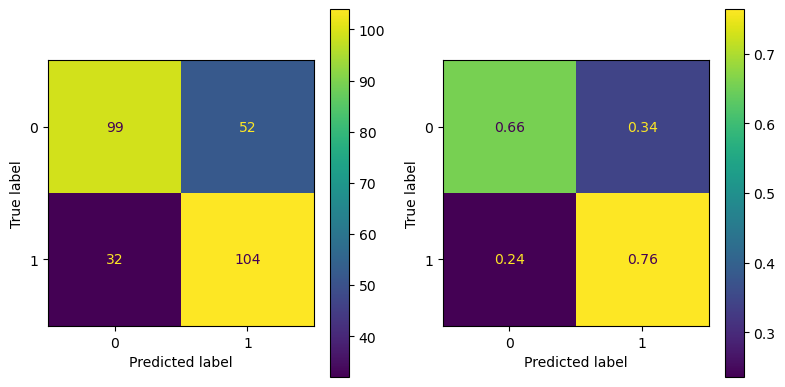

Model evaluation with val roc_auc_score:0.7897
roc_auc_score: 0.8162
f1_score: 0.7381
accuracy_score: 0.7700
recall_score: 0.6838


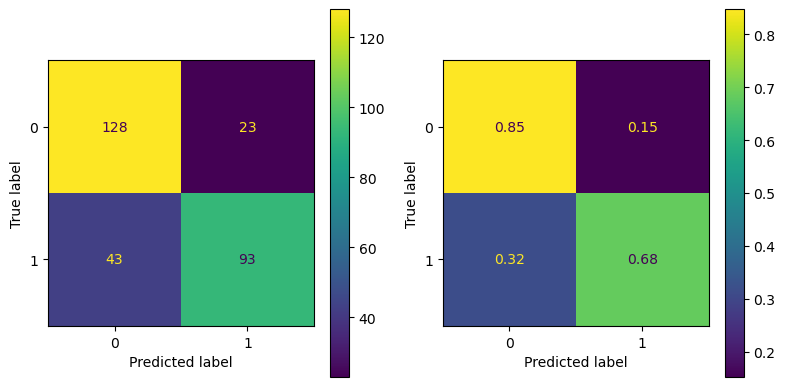

Model evaluation with val recall_score:0.7877
roc_auc_score: 0.7293
f1_score: 0.6465
accuracy_score: 0.5923
recall_score: 0.7868


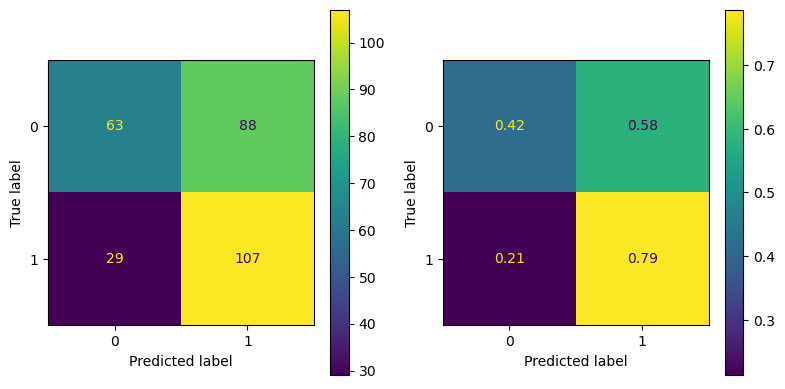

In [9]:
for i, (metric, (model, score)) in enumerate(best_afp_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with val {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()

### GAT

In [10]:
gat_model = lambda optimizer=None: dc.models.GATModel(
  mode='classification',
  n_tasks=1,
  learning_rate=0.001,
  device=torch.device('cuda'),
  optimizer=optimizer
)
best_gat_model = train_model(gat_model, train_feat, val_feat, transformer, save_dir='checkpoints/GAT_undersampled')

100%|██████████| 32/32.0 [00:01<00:00, 24.48it/s]


roc_auc_score: 0.6506, f1_score: 0.5447, accuracy_score: 0.5909, recall_score: 0.4795, train_loss: 0.4152, epoch: 0.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.99it/s]


roc_auc_score: 0.6627, f1_score: 0.5355, accuracy_score: 0.5997, recall_score: 0.4521, train_loss: 0.4001, epoch: 1.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.22it/s]


roc_auc_score: 0.6629, f1_score: 0.5479, accuracy_score: 0.5962, recall_score: 0.4795, train_loss: 0.3884, epoch: 2.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.99it/s]


roc_auc_score: 0.7105, f1_score: 0.5636, accuracy_score: 0.6399, recall_score: 0.4555, train_loss: 0.3834, epoch: 3.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.16it/s]


roc_auc_score: 0.7154, f1_score: 0.6264, accuracy_score: 0.6538, recall_score: 0.5685, train_loss: 0.3771, epoch: 4.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.06it/s]


roc_auc_score: 0.6892, f1_score: 0.4472, accuracy_score: 0.6154, recall_score: 0.3048, train_loss: 0.3732, epoch: 5.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.52it/s]


roc_auc_score: 0.7142, f1_score: 0.6741, accuracy_score: 0.6416, recall_score: 0.7260, train_loss: 0.3665, epoch: 6.0000


100%|██████████| 32/32.0 [00:01<00:00, 22.39it/s]


roc_auc_score: 0.7114, f1_score: 0.6133, accuracy_score: 0.6538, recall_score: 0.5377, train_loss: 0.3622, epoch: 7.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.55it/s]


roc_auc_score: 0.6946, f1_score: 0.6509, accuracy_score: 0.6381, recall_score: 0.6610, train_loss: 0.3647, epoch: 8.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.92it/s]


roc_auc_score: 0.7105, f1_score: 0.6700, accuracy_score: 0.6486, recall_score: 0.6986, train_loss: 0.3632, epoch: 9.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.56it/s]


roc_auc_score: 0.6817, f1_score: 0.6916, accuracy_score: 0.6259, recall_score: 0.8219, train_loss: 0.3606, epoch: 10.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.41it/s]


roc_auc_score: 0.7222, f1_score: 0.6677, accuracy_score: 0.6364, recall_score: 0.7158, train_loss: 0.3672, epoch: 11.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.58it/s]


roc_auc_score: 0.7135, f1_score: 0.6804, accuracy_score: 0.6189, recall_score: 0.7945, train_loss: 0.3547, epoch: 12.0000


100%|██████████| 32/32.0 [00:01<00:00, 25.17it/s]


roc_auc_score: 0.7316, f1_score: 0.6984, accuracy_score: 0.6451, recall_score: 0.8048, train_loss: 0.3635, epoch: 13.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.65it/s]


roc_auc_score: 0.7128, f1_score: 0.6118, accuracy_score: 0.6538, recall_score: 0.5342, train_loss: 0.3643, epoch: 14.0000


100%|██████████| 32/32.0 [00:01<00:00, 23.91it/s]


roc_auc_score: 0.7222, f1_score: 0.6172, accuracy_score: 0.6661, recall_score: 0.5274, train_loss: 0.3555, epoch: 15.0000


100%|██████████| 32/32.0 [00:01<00:00, 22.11it/s]


roc_auc_score: 0.7373, f1_score: 0.6899, accuracy_score: 0.6573, recall_score: 0.7466, train_loss: 0.3519, epoch: 16.0000


100%|██████████| 32/32.0 [00:01<00:00, 24.70it/s]


roc_auc_score: 0.7277, f1_score: 0.6170, accuracy_score: 0.6766, recall_score: 0.5103, train_loss: 0.3478, epoch: 17.0000


100%|██████████| 32/32.0 [00:01<00:00, 20.89it/s]


roc_auc_score: 0.7237, f1_score: 0.6936, accuracy_score: 0.6294, recall_score: 0.8219, train_loss: 0.3455, epoch: 18.0000


100%|██████████| 32/32.0 [00:01<00:00, 18.26it/s]


roc_auc_score: 0.7257, f1_score: 0.5752, accuracy_score: 0.6643, recall_score: 0.4452, train_loss: 0.3516, epoch: 19.0000


100%|██████████| 32/32.0 [00:01<00:00, 18.32it/s]


roc_auc_score: 0.7138, f1_score: 0.5745, accuracy_score: 0.6556, recall_score: 0.4555, train_loss: 0.3470, epoch: 20.0000


100%|██████████| 32/32.0 [00:01<00:00, 18.42it/s]


roc_auc_score: 0.7231, f1_score: 0.6402, accuracy_score: 0.6836, recall_score: 0.5514, train_loss: 0.3477, epoch: 21.0000


100%|██████████| 32/32.0 [00:01<00:00, 18.19it/s]


roc_auc_score: 0.7526, f1_score: 0.7057, accuracy_score: 0.7185, recall_score: 0.6610, train_loss: 0.3363, epoch: 22.0000


100%|██████████| 32/32.0 [00:01<00:00, 17.41it/s]


roc_auc_score: 0.7478, f1_score: 0.6793, accuracy_score: 0.7045, recall_score: 0.6130, train_loss: 0.3325, epoch: 23.0000


100%|██████████| 32/32.0 [00:04<00:00,  6.68it/s]


roc_auc_score: 0.7678, f1_score: 0.6880, accuracy_score: 0.7098, recall_score: 0.6267, train_loss: 0.3341, epoch: 24.0000


100%|██████████| 32/32.0 [00:03<00:00,  8.92it/s]


roc_auc_score: 0.7584, f1_score: 0.6395, accuracy_score: 0.7063, recall_score: 0.5103, train_loss: 0.3256, epoch: 25.0000


100%|██████████| 32/32.0 [00:01<00:00, 17.65it/s]


roc_auc_score: 0.7624, f1_score: 0.7111, accuracy_score: 0.7045, recall_score: 0.7123, train_loss: 0.3233, epoch: 26.0000


100%|██████████| 32/32.0 [00:01<00:00, 16.69it/s]


roc_auc_score: 0.7665, f1_score: 0.7075, accuracy_score: 0.6661, recall_score: 0.7911, train_loss: 0.3271, epoch: 27.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.42it/s]


roc_auc_score: 0.7589, f1_score: 0.7050, accuracy_score: 0.6678, recall_score: 0.7774, train_loss: 0.3244, epoch: 28.0000


100%|██████████| 32/32.0 [00:04<00:00,  7.53it/s]


roc_auc_score: 0.7520, f1_score: 0.6427, accuracy_score: 0.7045, recall_score: 0.5205, train_loss: 0.3241, epoch: 29.0000


100%|██████████| 32/32.0 [00:03<00:00,  9.37it/s]


roc_auc_score: 0.7632, f1_score: 0.6707, accuracy_score: 0.7115, recall_score: 0.5753, train_loss: 0.3240, epoch: 30.0000


100%|██████████| 32/32.0 [00:01<00:00, 17.85it/s]


roc_auc_score: 0.7680, f1_score: 0.7089, accuracy_score: 0.7028, recall_score: 0.7089, train_loss: 0.3297, epoch: 31.0000


100%|██████████| 32/32.0 [00:02<00:00, 11.79it/s]


roc_auc_score: 0.7482, f1_score: 0.7067, accuracy_score: 0.6923, recall_score: 0.7260, train_loss: 0.3179, epoch: 32.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.58it/s]


roc_auc_score: 0.7723, f1_score: 0.7148, accuracy_score: 0.6958, recall_score: 0.7466, train_loss: 0.3125, epoch: 33.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.26it/s]


roc_auc_score: 0.7629, f1_score: 0.4364, accuracy_score: 0.6206, recall_score: 0.2877, train_loss: 0.3174, epoch: 34.0000


100%|██████████| 32/32.0 [00:01<00:00, 19.57it/s]


roc_auc_score: 0.7478, f1_score: 0.6654, accuracy_score: 0.6923, recall_score: 0.5993, train_loss: 0.3193, epoch: 35.0000


100%|██████████| 32/32.0 [00:02<00:00, 15.10it/s]


roc_auc_score: 0.7710, f1_score: 0.7319, accuracy_score: 0.7028, recall_score: 0.7945, train_loss: 0.3137, epoch: 36.0000


100%|██████████| 32/32.0 [00:01<00:00, 17.89it/s]


roc_auc_score: 0.7580, f1_score: 0.6886, accuracy_score: 0.7185, recall_score: 0.6096, train_loss: 0.3090, epoch: 37.0000


100%|██████████| 32/32.0 [00:01<00:00, 18.31it/s]


roc_auc_score: 0.7673, f1_score: 0.7178, accuracy_score: 0.6976, recall_score: 0.7534, train_loss: 0.3086, epoch: 38.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.51it/s]


roc_auc_score: 0.7705, f1_score: 0.6924, accuracy_score: 0.7080, recall_score: 0.6438, train_loss: 0.3095, epoch: 39.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.35it/s]


roc_auc_score: 0.7619, f1_score: 0.6707, accuracy_score: 0.7168, recall_score: 0.5651, train_loss: 0.3092, epoch: 40.0000


100%|██████████| 32/32.0 [00:02<00:00, 15.47it/s]


roc_auc_score: 0.7617, f1_score: 0.7075, accuracy_score: 0.6748, recall_score: 0.7705, train_loss: 0.3064, epoch: 41.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.40it/s]


roc_auc_score: 0.7587, f1_score: 0.7007, accuracy_score: 0.7028, recall_score: 0.6815, train_loss: 0.3032, epoch: 42.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.85it/s]


roc_auc_score: 0.7718, f1_score: 0.7033, accuracy_score: 0.7168, recall_score: 0.6575, train_loss: 0.2986, epoch: 43.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.25it/s]


roc_auc_score: 0.7579, f1_score: 0.6769, accuracy_score: 0.7045, recall_score: 0.6062, train_loss: 0.3089, epoch: 44.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.38it/s]


roc_auc_score: 0.7668, f1_score: 0.7126, accuracy_score: 0.6941, recall_score: 0.7432, train_loss: 0.3047, epoch: 45.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.74it/s]


roc_auc_score: 0.7738, f1_score: 0.6937, accuracy_score: 0.7098, recall_score: 0.6438, train_loss: 0.2972, epoch: 46.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.16it/s]


roc_auc_score: 0.7661, f1_score: 0.6598, accuracy_score: 0.7115, recall_score: 0.5479, train_loss: 0.2892, epoch: 47.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.63it/s]


roc_auc_score: 0.7597, f1_score: 0.6904, accuracy_score: 0.6346, recall_score: 0.7979, train_loss: 0.2950, epoch: 48.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.34it/s]


roc_auc_score: 0.7519, f1_score: 0.6296, accuracy_score: 0.6976, recall_score: 0.5034, train_loss: 0.2958, epoch: 49.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.26it/s]


roc_auc_score: 0.7376, f1_score: 0.6203, accuracy_score: 0.6853, recall_score: 0.5034, train_loss: 0.2898, epoch: 50.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.45it/s]


roc_auc_score: 0.7577, f1_score: 0.6458, accuracy_score: 0.7028, recall_score: 0.5308, train_loss: 0.2885, epoch: 51.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.39it/s]


roc_auc_score: 0.7480, f1_score: 0.6887, accuracy_score: 0.6049, recall_score: 0.8562, train_loss: 0.2875, epoch: 52.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.03it/s]


roc_auc_score: 0.7579, f1_score: 0.6766, accuracy_score: 0.6976, recall_score: 0.6199, train_loss: 0.2826, epoch: 53.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.21it/s]


roc_auc_score: 0.7614, f1_score: 0.6756, accuracy_score: 0.7045, recall_score: 0.6027, train_loss: 0.2863, epoch: 54.0000


100%|██████████| 32/32.0 [00:02<00:00, 12.98it/s]


roc_auc_score: 0.7705, f1_score: 0.7165, accuracy_score: 0.7080, recall_score: 0.7226, train_loss: 0.2878, epoch: 55.0000


100%|██████████| 32/32.0 [00:02<00:00, 12.82it/s]


roc_auc_score: 0.7646, f1_score: 0.6680, accuracy_score: 0.6993, recall_score: 0.5925, train_loss: 0.2783, epoch: 56.0000


100%|██████████| 32/32.0 [00:02<00:00, 13.55it/s]


roc_auc_score: 0.7686, f1_score: 0.7067, accuracy_score: 0.7098, recall_score: 0.6849, train_loss: 0.2779, epoch: 57.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.01it/s]


roc_auc_score: 0.7426, f1_score: 0.6200, accuracy_score: 0.6871, recall_score: 0.5000, train_loss: 0.2824, epoch: 58.0000


100%|██████████| 32/32.0 [00:02<00:00, 14.16it/s]


roc_auc_score: 0.7686, f1_score: 0.6910, accuracy_score: 0.7185, recall_score: 0.6164, train_loss: 0.2761, epoch: 59.0000


Model evaluation with val f1_score:0.7319
roc_auc_score: 0.8029
f1_score: 0.6943
accuracy_score: 0.6655
recall_score: 0.8015


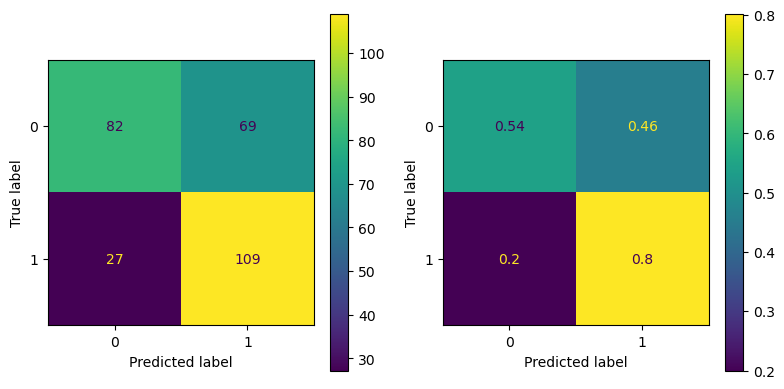

Model evaluation with val roc_auc_score:0.7738
roc_auc_score: 0.7948
f1_score: 0.7068
accuracy_score: 0.7282
recall_score: 0.6912


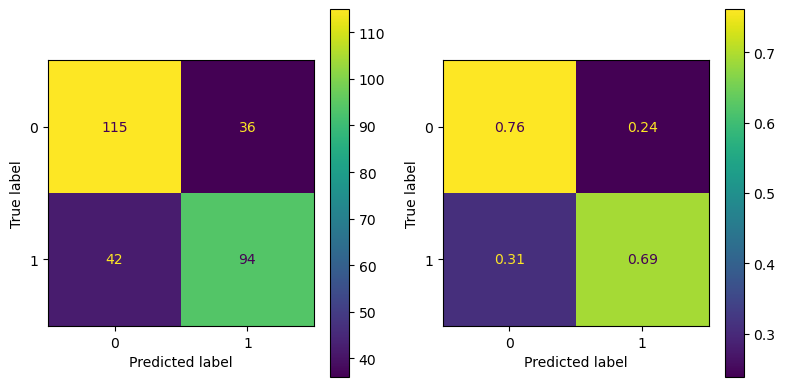

Model evaluation with val recall_score:0.8562
roc_auc_score: 0.7731
f1_score: 0.6686
accuracy_score: 0.5958
recall_score: 0.8603


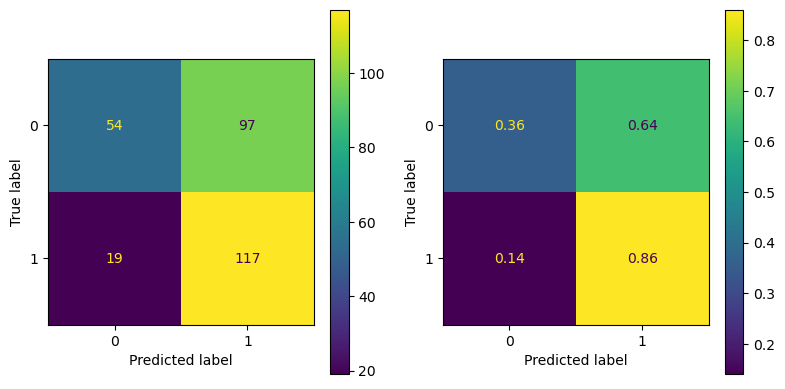

In [11]:
for i, (metric, (model, score)) in enumerate(best_gat_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with val {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()